In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from soupsieve.util import lower

In [306]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# customers_dataset

In [307]:
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [308]:
customers_df.shape

(99441, 5)

In [309]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [310]:
# 전체 주문 건수: 99,441건
customers_df['customer_id'].nunique()

99441

In [311]:
# 고유 고객 수: 96,096명
customers_df['customer_unique_id'].nunique()

96096

In [312]:
unique_customer_df = customers_df.groupby('customer_unique_id').agg({
    'customer_id': 'count',
    'customer_city': 'nunique',
    'customer_state': 'nunique'
}).reset_index()

unique_customer_df.columns = ['customer_unique_id', 'unique_order_count', 'unique_city_count', 'unique_state_count']

# 재구매 고객 수: 2,997명
unique_customer_df = unique_customer_df.sort_values('unique_order_count', ascending=False)
multi_order_customers = unique_customer_df[unique_customer_df['unique_order_count'] > 1]
print(multi_order_customers['customer_unique_id'].count())

# 도시 2개 이상 고객 수: 122명
multi_city_customers = unique_customer_df[unique_customer_df['unique_city_count'] > 1]
print(multi_city_customers['customer_unique_id'].count())

# 주 2개 이상 고객 수: 39명
multi_state_customers = unique_customer_df[unique_customer_df['unique_state_count'] > 1]
print(multi_state_customers['customer_unique_id'].count())

2997
122
39


## 2회 이상 구매 고객 필터링

In [313]:
filtered_customers = customers_df[customers_df['customer_unique_id'].isin(multi_order_customers['customer_unique_id'])]

filtered_customers.shape

(6342, 5)

In [314]:
# 고유 주(state) 수: 27
filtered_customers['customer_state'].nunique()

27

In [315]:
# 전체 주문 건수의 80%를 차지하는 state 비중
state_counts = filtered_customers['customer_state'].value_counts().sort_values(ascending=False)
total_customers = state_counts.sum()
cumsum_customers = state_counts.cumsum()
top_states_mask = cumsum_customers <= total_customers * 0.8
top_states_count = top_states_mask.sum()

total_states = state_counts.shape[0]
top_states_ratio = top_states_count / total_states * 100

print(f"전체 주문 건수의 80%를 차지하는 state 수: {top_states_count}개")
print(f"전체 state 수 중 비율: {top_states_ratio:.2f}%")

전체 주문 건수의 80%를 차지하는 state 수: 5개
전체 state 수 중 비율: 18.52%


In [316]:
# 전체 주문 건수의 80%를 차지하는 state 리스트
state_cumsum_ratio = state_counts.cumsum() / state_counts.sum()
top_states = state_cumsum_ratio[state_cumsum_ratio <= 0.8].index.tolist()

print(f"전체 주문 건수의 80%를 차지하는 주 리스트:\n{top_states}")
# ['SP', 'RJ', 'MG', 'RS', 'PR']
# [상파울루, 리우데자네이루, 미나스제라이스, 리오그란데두술, 파라나]

전체 주문 건수의 80%를 차지하는 주 리스트:
['SP', 'RJ', 'MG', 'RS', 'PR']


In [317]:
customer_ratio_by_state = state_counts / total_customers
customer_ratio_by_state['SP'].round(2)

0.43

# geolocation_dataset

In [318]:
geolocation_df = pd.read_csv('data/olist_geolocation_dataset.csv')
geolocation_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [319]:
geolocation_df.shape

(1000163, 5)

In [320]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [321]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [322]:
# 전체 주문 건수의 80%를 차지하는 state 시각화
import folium

# 주별 중심 도시 위치 정보 (주 약어 -> [위도, 경도])
state_coords = {
    'SP': [-23.5505, -46.6333],  # São Paulo
    'RJ': [-22.9068, -43.1729],  # Rio de Janeiro
    'MG': [-19.9167, -43.9345],  # Belo Horizonte
    'RS': [-30.0346, -51.2177],  # Porto Alegre
    'PR': [-25.4284, -49.2733],  # Curitiba
}

# 주 이름 매핑
state_names = {
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    'MG': 'Minas Gerais',
    'RS': 'Rio Grande do Sul',
    'PR': 'Paraná',
}

# 고객 비율
cust_count = {
    'SP': customer_ratio_by_state['SP'].round(2),
    'RJ': customer_ratio_by_state['RJ'].round(2),
    'MG': customer_ratio_by_state['MG'].round(2),
    'RS': customer_ratio_by_state['RS'].round(2),
    'PR': customer_ratio_by_state['PR'].round(2)
}

# 중심 좌표는 브라질 중앙 근처
m = folium.Map(location=[-15.7885, -47.8799], zoom_start=4)

# 마커 표시 (비중에 비례한 반지름으로)
for state_code, coords in state_coords.items():
    percentage = cust_count[state_code]
    radius = percentage * 100  # 반지름 조정 (예: 0.42 → 42)
    folium.CircleMarker(
        location=coords,
        radius=radius,
        popup=f"{state_names[state_code]}: {percentage:.2f}%",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

    # 주 이름 텍스트 레이블 추가
    folium.Marker(
        location=[coords[0] + 0.5, coords[1] + 0.5],  # 위치 약간 위로 조정
        icon=folium.DivIcon(html=f'<div style="font-size:10pt; font-weight:bold">{state_names[state_code]}</div>')
    ).add_to(m)

m

# order_items_dataset

In [323]:
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [324]:
order_items_df.shape

(112650, 7)

In [325]:
# 날짜 데이터 형변환 필요
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [326]:
# 고유 판매자 수: 3,095명
order_items_df['seller_id'].nunique()

3095

In [327]:
# 판매자별 매출
order_items_df.groupby('seller_id')['price'].sum().sort_values(ascending=False)

seller_id
4869f7a5dfa277a7dca6462dcf3b52b2    229472.63
53243585a1d6dc2643021fd1853d8905    222776.05
4a3ca9315b744ce9f8e9374361493884    200472.92
fa1c13f2614d7b5c4749cbc52fecda94    194042.03
7c67e1448b00f6e969d365cea6b010ab    187923.89
                                      ...    
34aefe746cd81b7f3b23253ea28bef39         8.00
702835e4b785b67a084280efca355756         7.60
1fa2d3def6adfa70e58c276bb64fe5bb         6.90
77128dec4bec4878c37ab7d6169d6f26         6.50
cf6f6bc4df3999b9c6440f124fb2f687         3.50
Name: price, Length: 3095, dtype: float64

In [328]:
# 매출 80% 판매자 비중
seller_revenue = order_items_df.groupby('seller_id')['price'].sum().sort_values(ascending=False)
total_revenue = seller_revenue.sum()
threshold = total_revenue * 0.80  # 매출 80%

cumsum_revenue = seller_revenue.cumsum()
top_sellers_mask = cumsum_revenue <= threshold
top_sellers_count = top_sellers_mask.sum()

total_sellers = seller_revenue.shape[0]
top_sellers_ratio = top_sellers_count / total_sellers * 100

print(f"총 매출의 80%를 차지하는 판매자 수: {top_sellers_count}명")
print(f"전체 판매자 중 비중: {top_sellers_ratio:.2f}%")

총 매출의 80%를 차지하는 판매자 수: 543명
전체 판매자 중 비중: 17.54%


# sellers_dataset

In [329]:
sellers_df = pd.read_csv('data/olist_sellers_dataset.csv')
sellers_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [330]:
sellers_df.shape

(3095, 4)

In [331]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [332]:
# 전체 판매자 수의 80%를 차지하는 state 시각화
state_counts = sellers_df['seller_state'].value_counts().sort_values(ascending=False)
total_sellers = state_counts.sum()
cumsum_sellers = state_counts.cumsum()
top_states_mask = cumsum_sellers <= total_sellers * 0.8
top_states_count = top_states_mask.sum()

total_states = state_counts.shape[0]
top_states_ratio = top_states_count / total_states * 100

print(f"전체 판매자 수의 80%를 차지하는 state 수: {top_states_count}개")
print(f"전체 state 수 중 비율: {top_states_ratio:.2f}%")

전체 판매자 수의 80%를 차지하는 state 수: 3개
전체 state 수 중 비율: 13.04%


In [333]:
# 전체 판매자 수의 80%를 차지하는 state 리스트
state_cumsum_ratio = state_counts.cumsum() / state_counts.sum()
top_states = state_cumsum_ratio[state_cumsum_ratio <= 0.8].index.tolist()

print(f"전체 판매자 수의 80%를 차지하는 주 리스트:\n{top_states}")
# ['SP', 'PR', 'MG']
# [상파울루, 파라나, 미나스제라이스]

전체 판매자 수의 80%를 차지하는 주 리스트:
['SP', 'PR', 'MG']


In [334]:
seller_ratio_by_state = state_counts / total_sellers
seller_ratio_by_state['SP'].round(2)

0.6

In [335]:
# 전체 판매자 수의 80%를 차지하는 state 시각화
# 'SP', 'PR', 'MG' 주별 판매자 비율 딕셔너리
seller_ratio = {
    'SP': seller_ratio_by_state['SP'].round(2),
    'PR': seller_ratio_by_state['PR'].round(2),
    'MG': seller_ratio_by_state['MG'].round(2)
}

# 주별 중심 도시 좌표
state_coords = {
    'SP': [-23.5505, -46.6333],  # São Paulo
    'PR': [-25.4284, -49.2733],  # Curitiba
    'MG': [-19.9167, -43.9345],  # Belo Horizonte
}

# Folium 지도 생성
m = folium.Map(location=[-20.0, -47.0], zoom_start=5)

# 원 크기를 비례하게 설정하여 지도에 표시
for state, percentage in seller_ratio.items():
    coords = state_coords[state]
    radius = percentage * 100  # 예: 0.42 → 42

    folium.CircleMarker(
        location=coords,
        radius=radius,
        popup=f"{state}: {percentage*100:.2f}%",
        tooltip=state,
        color='darkblue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.7
    ).add_to(m)

    # 주 이름 텍스트 레이블 추가
    folium.Marker(
        location=[coords[0] + 0.5, coords[1] + 0.5],  # 위치 약간 위로 조정
        icon=folium.DivIcon(html=f'<div style="font-size:10pt; font-weight:bold">{state_names[state]}</div>')
    ).add_to(m)

m

# order_payments_dataset

In [336]:
order_payments_df = pd.read_csv('data/olist_order_payments_dataset.csv')
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [337]:
order_payments_df.shape

(103886, 5)

In [338]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [339]:
# 결제 수단별 빈도
order_payments_df['payment_type'].value_counts()
# credit_card: 신용카드
# boleto: 청구서 (브라질 특유의 결제 방식 - 은행 고지서 방식)
# voucher: 상품권/바우처
# debit_card: 체크카드
# not_defined: 미정

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [340]:
# 결제 수단별 결제금액 합계
order_payments_df.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)

payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64

In [341]:
# 할부 횟수 범위: 0~24회
order_payments_df['payment_installments'].describe()

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

# order_reviews_dataset

In [342]:
order_reviews_df = pd.read_csv('data/olist_order_reviews_dataset.csv')
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [343]:
# 날짜 데이터 형변환 필요
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [344]:
order_reviews_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [345]:
order_reviews_df.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [346]:
# 리뷰 작성한 고객 수: 98,673명
order_reviews_df['order_id'].nunique()

98673

# orders_dataset

In [347]:
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [348]:
orders_df.shape

(99441, 8)

In [349]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [350]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [351]:
# 타겟 컬럼(결측치 없음)
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_purchase_timestamp'].describe()

count                            99441
mean     2017-12-31 08:43:12.776581120
min                2016-09-04 21:15:19
25%                2017-09-12 14:46:19
50%                2018-01-18 23:04:36
75%                2018-05-04 15:42:16
max                2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: object

In [352]:
# customer_unique_id 병합
orders_df = pd.merge(
    orders_df,
    customers_df[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


## 2회 이상 구매 고객 필터링

In [353]:
filtered_customers = orders_df[orders_df['customer_unique_id'].isin(multi_order_customers['customer_unique_id'])]

print(filtered_customers.shape)
print(filtered_customers['customer_unique_id'].nunique())

(6342, 9)
2997


In [354]:
# 고객별 주문 횟
purchase_frequency = filtered_customers.groupby('customer_unique_id').size().reset_index(name='purchase_count')

# 구매 빈도 내림차순 정렬
purchase_frequency = purchase_frequency.sort_values(by='purchase_count', ascending=False)

# 결과 확인
purchase_frequency['customer_unique_id'].nunique()
purchase_frequency.head()

,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7


In [355]:
purchase_frequency['purchase_count'].describe()

count    2997.000000
mean        2.116116
std         0.516610
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        17.000000
Name: purchase_count, dtype: float64

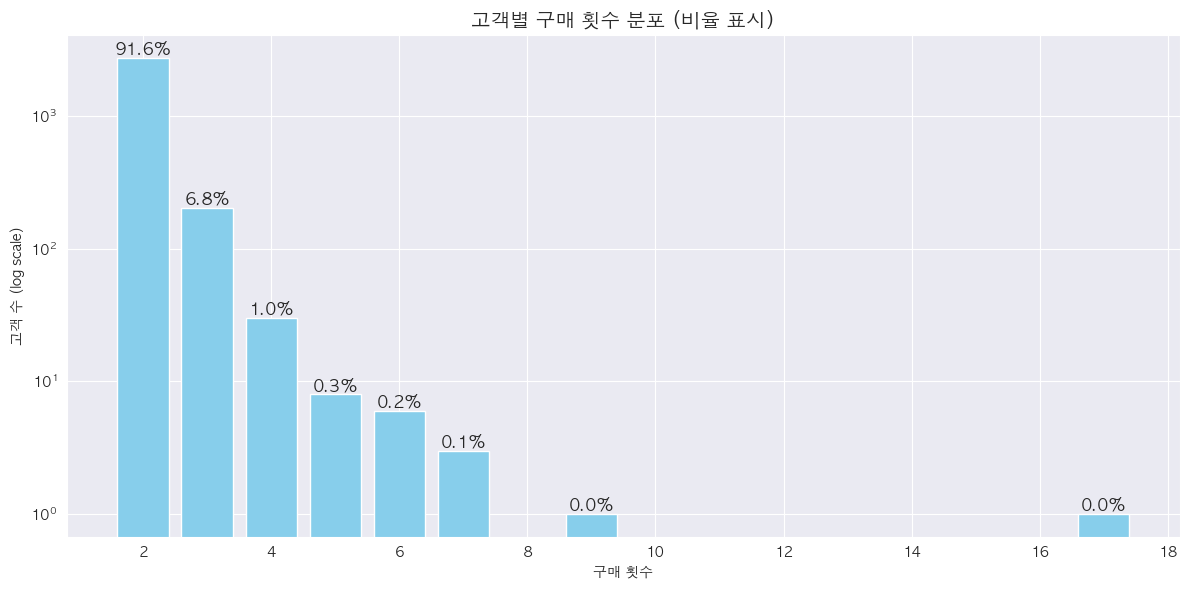

In [356]:
# 구매 횟수 빈도
counts = purchase_frequency['purchase_count'].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.yscale('log')  # 로그 스케일
plt.title('고객별 구매 횟수 분포 (비율 표시)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수 (log scale)')
plt.grid(True)

# 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:  # 0인 경우 표시 생략
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%',
                 ha='center', va='bottom', fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


In [357]:
# 이상치 추출
Q1 = purchase_frequency['purchase_count'].quantile(0.25)
Q3 = purchase_frequency['purchase_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = purchase_frequency[
    (purchase_frequency['purchase_count'] < lower_bound) |
    (purchase_frequency['purchase_count'] > upper_bound)
]

outlier_ratio = len(outliers) / filtered_customers['customer_unique_id'].nunique() * 100
print("이상치 수:", len(outliers))
print(f"이상치 비중: {outlier_ratio:.2f}%")
display(outliers.sort_values(by='purchase_count', ascending=False))
print("upper bound:", upper_bound)

이상치 수: 252
이상치 비중: 8.41%


,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7
...,...,...
1878,9d31457a03125fc870787a251760315a,3
1982,a72a2d4e19868dba726c0e6f49198c7e,3
2624,df946ef265626b1e0a425292815ddead,3
1904,a029899dd8534557a81c369475ff80c8,3


upper bound: 2.0


In [358]:
# 4회 이상 구매 고객 비율:  약 1.6%
filtered_freq = purchase_frequency[purchase_frequency['purchase_count'] > 3]
filtered_freq['customer_unique_id'].nunique() / purchase_frequency['customer_unique_id'].nunique() * 100

filtered_freq

,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7
2592,dc813062e0fc23409cd255f7f53c7074,6
2845,f0e310a6839dce9de1638e0fe5ab282a,6
2612,de34b16117594161a6a89c50b289d35a,6
228,12f5d6e1cbf93dafd9dcc19095df0b3d,6
824,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


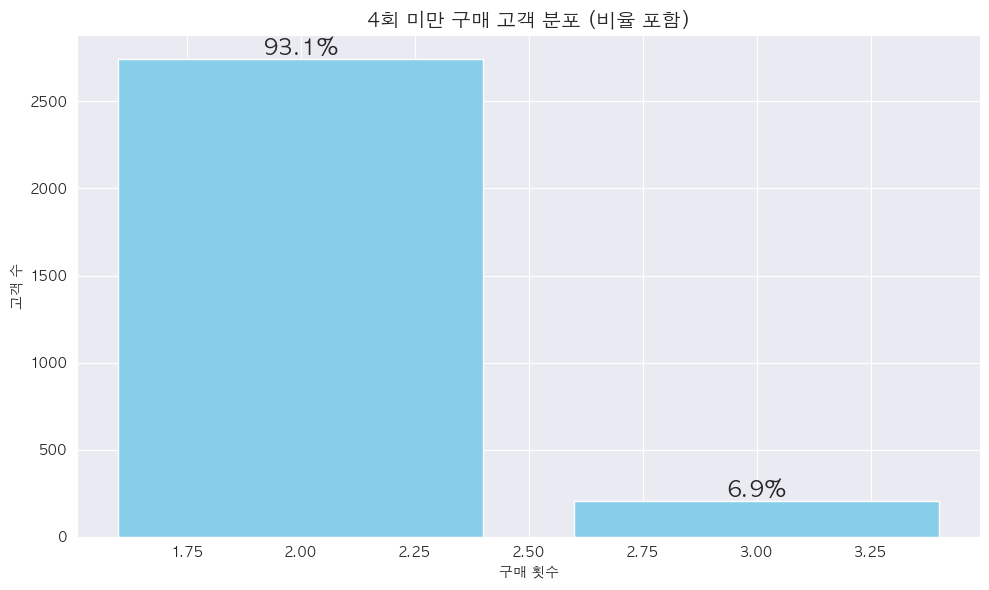

In [359]:
# 이상치 제거 (4회 이상)
import matplotlib.pyplot as plt

# ▶ 4회 미만 구매 고객만 추출
filtered_freq = purchase_frequency[purchase_frequency['purchase_count'] < 4]

# ▶ 구매 횟수별 고객 수와 비율 계산
counts = filtered_freq['purchase_count'].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

# ▶ 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.title('4회 미만 구매 고객 분포 (비율 포함)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수')
plt.grid(True, axis='y')

# ▶ 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # 가운데 정렬
        height,                            # 막대 위
        f'{pct:.1f}%',                     # 표시할 비율
        ha='center',
        va='bottom',
        fontsize=16
    )

plt.tight_layout()
plt.show()

In [360]:
# 1~3회 구매 고객만 필터링
filtered_customers = filtered_customers[filtered_customers['customer_unique_id'].isin(filtered_freq['customer_unique_id'])]

# 인덱스 정리
filtered_customers = filtered_customers.reset_index(drop=True)

# 결과 확인
filtered_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f
2,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5
3,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259
4,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,delivered,2017-05-14 20:28:25,2017-05-14 20:42:45,2017-05-16 08:17:46,2017-05-25 09:14:31,2017-06-12 00:00:00,c2551ea089b7ebbc67a2ea8757152514


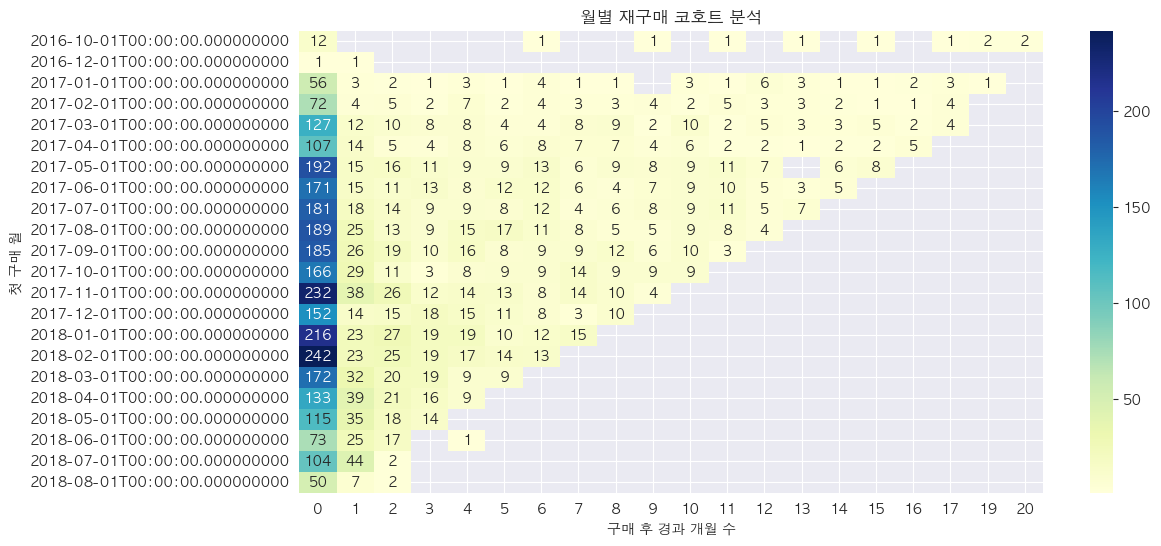

In [361]:
# 재구매 월별 코호트
filtered_customers = filtered_customers.copy()

filtered_customers['order_month'] = filtered_customers['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

first_order = filtered_customers.groupby('customer_unique_id')['order_month'].min().reset_index()
first_order.columns = ['customer_unique_id', 'cohort_month']

orders_cohort = pd.merge(filtered_customers, first_order, on='customer_unique_id')

def get_month_diff(df):
    return (df['order_month'].dt.year - df['cohort_month'].dt.year) * 12 + (df['order_month'].dt.month - df['cohort_month'].dt.month)

orders_cohort['cohort_index'] = get_month_diff(orders_cohort)

cohort_counts = orders_cohort.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

plt.figure(figsize=(12, 6))
sns.heatmap(cohort_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('월별 재구매 코호트 분석')
plt.xlabel('구매 후 경과 개월 수')
plt.ylabel('첫 구매 월')
plt.show()

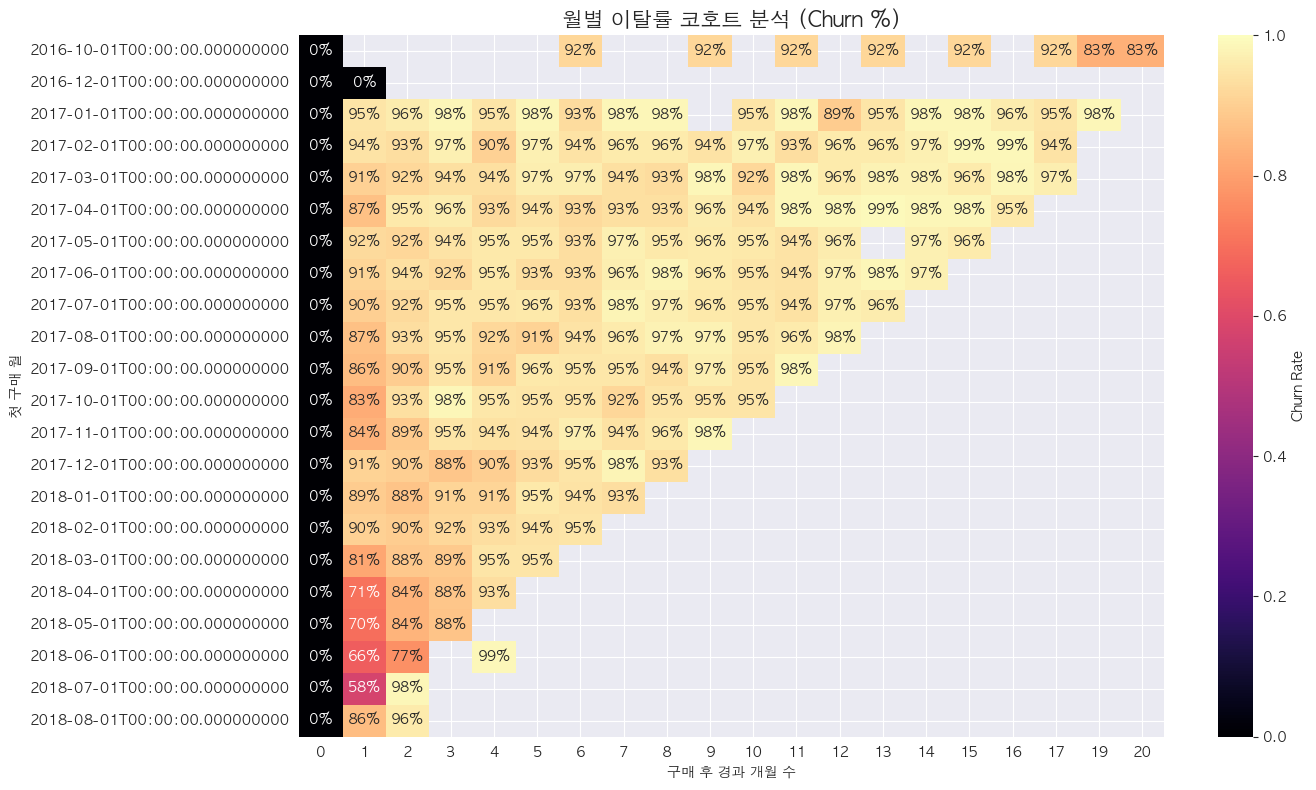

In [362]:
# 이탈률 월별 코호트

# 월별 전처리
filtered_customers['order_month'] = filtered_customers['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# 고객별 첫 주문 월
first_order = filtered_customers.groupby('customer_unique_id')['order_month'].min().reset_index()
first_order.columns = ['customer_unique_id', 'cohort_month']

# 병합 및 코호트 인덱스 계산
orders_cohort = pd.merge(filtered_customers, first_order, on='customer_unique_id')
orders_cohort['cohort_index'] = (
    (orders_cohort['order_month'].dt.year - orders_cohort['cohort_month'].dt.year) * 12 +
    (orders_cohort['order_month'].dt.month - orders_cohort['cohort_month'].dt.month)
)

# 월별 고유 고객 수
cohort_counts = orders_cohort.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

# ▶ 유지율 계산
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# ▶ 이탈률 계산 (1 - 유지율)
churn_rate = 1 - retention

# ▶ 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(
    churn_rate,
    annot=True,
    fmt=".0%",
    cmap='magma',  # 이탈률에 적합한 강한 대비 색상
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'Churn Rate'}
)

plt.title('월별 이탈률 코호트 분석 (Churn %)', fontsize=15)
plt.xlabel('구매 후 경과 개월 수')
plt.ylabel('첫 구매 월')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [363]:
# 년도별 첫 구매 고객 이탈률 분석

# 1) 고객별 첫 구매일 추출
first_purchase = filtered_customers.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_purchase.columns = ['customer_unique_id', 'first_purchase_date']

# 2) 병합
orders = filtered_customers.merge(first_purchase, on='customer_unique_id', how='left')

# 3) 주 단위 코호트 생성 함수
def get_week_period(date):
    year = date.isocalendar().year
    week = date.isocalendar().week
    return f'{year}-W{week:02d}'

# 4) 코호트 컬럼 생성
orders['first_purchase_week'] = orders['first_purchase_date'].apply(get_week_period)
orders['order_week'] = orders['order_purchase_timestamp'].apply(get_week_period)

# 5) 주차 차이 계산 함수
def week_diff(row):
    y1, w1 = row['first_purchase_week'].split('-W')
    y2, w2 = row['order_week'].split('-W')
    diff_year = int(y2) - int(y1)
    diff_week = int(w2) - int(w1)
    return diff_year * 52 + diff_week

orders['weeks_since_first'] = orders.apply(week_diff, axis=1)

# 6) 2016~2018년 첫 구매 고객만 필터링
orders['first_purchase_year'] = orders['first_purchase_date'].dt.year
orders = orders[orders['first_purchase_year'].isin([2016, 2017, 2018])]

# 7) 코호트 사이즈 계산
cohort_sizes = first_purchase[first_purchase['first_purchase_date'].dt.year.isin([2016, 2017, 2018])].copy()
cohort_sizes['first_purchase_week'] = cohort_sizes['first_purchase_date'].apply(get_week_period)
cohort_sizes = cohort_sizes.groupby('first_purchase_week')['customer_unique_id'].nunique().reset_index()
cohort_sizes.columns = ['cohort_week', 'cohort_size']

# 8) 주차별 재구매 고객 수 집계
repeat_purchases = orders.groupby(['first_purchase_week', 'weeks_since_first'])['customer_unique_id'].nunique().reset_index()
repeat_purchases.columns = ['cohort_week', 'weeks_since_first', 'active_customers']

# 9) 병합 및 이탈률 계산
cohort_data = repeat_purchases.merge(cohort_sizes, on='cohort_week')
cohort_data['retention_rate'] = cohort_data['active_customers'] / cohort_data['cohort_size']
cohort_data['churn_rate'] = 1 - cohort_data['retention_rate']

# 10) 확인
print(cohort_data.head())

  cohort_week  weeks_since_first  active_customers  cohort_size  \
0    2016-W40                  0                11           11   
1    2016-W40                 27                 1           11   
2    2016-W40                 42                 1           11   
3    2016-W40                 51                 1           11   
4    2016-W40                 57                 1           11   

   retention_rate  churn_rate  
0        1.000000    0.000000  
1        0.090909    0.909091  
2        0.090909    0.909091  
3        0.090909    0.909091  
4        0.090909    0.909091  


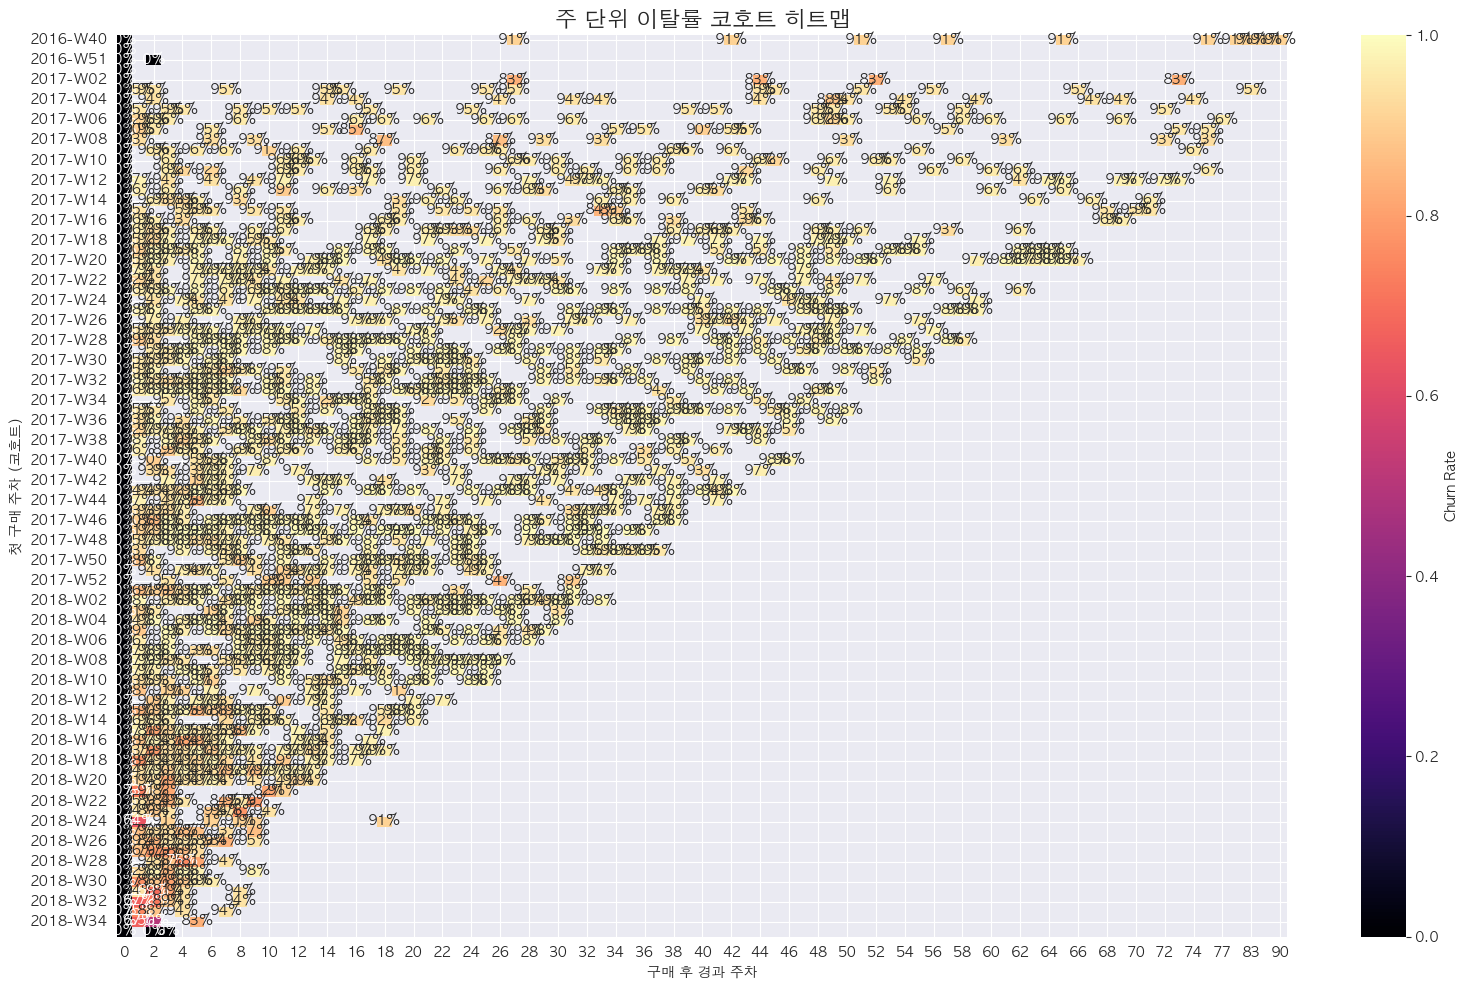

In [364]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Pivot 테이블로 변환 (행: 코호트 시작 주, 열: 경과 주차)
churn_pivot = cohort_data.pivot(index='cohort_week', columns='weeks_since_first', values='churn_rate')

# 2) 히트맵 시각화
plt.figure(figsize=(16, 10))
sns.heatmap(
    churn_pivot,
    annot=True,         # 각 셀에 수치 표시
    fmt=".0%",          # 백분율 형식
    cmap='magma',       # 대비 강한 컬러맵
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'Churn Rate'}
)

plt.title('주 단위 이탈률 코호트 히트맵', fontsize=16)
plt.xlabel('구매 후 경과 주차')
plt.ylabel('첫 구매 주차 (코호트)')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

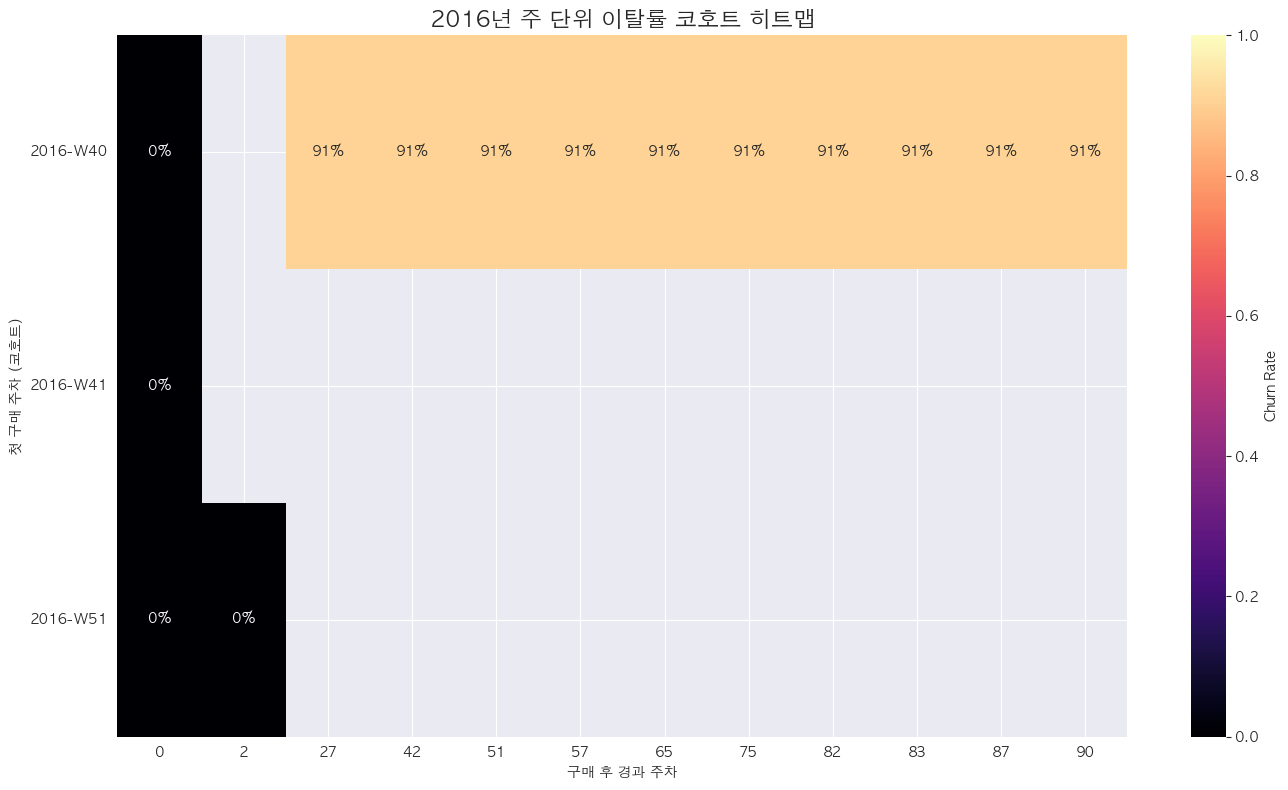

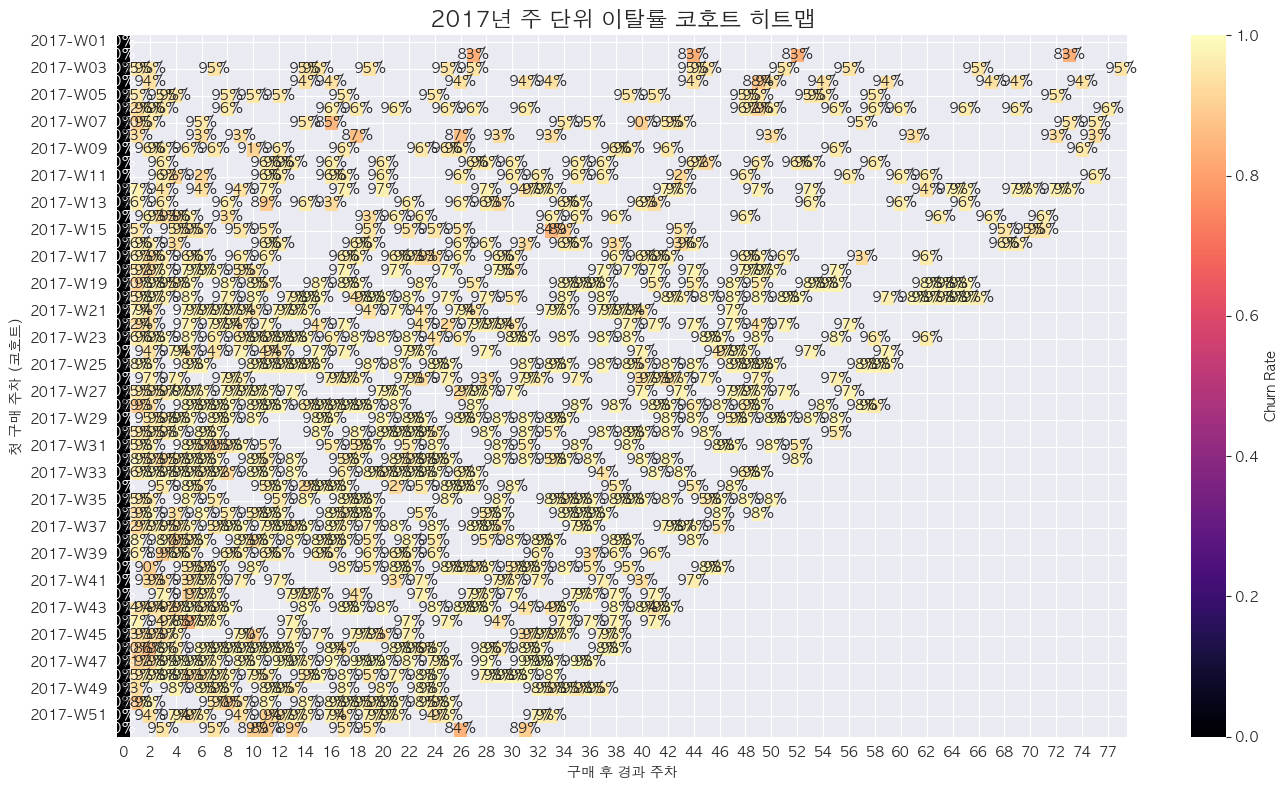

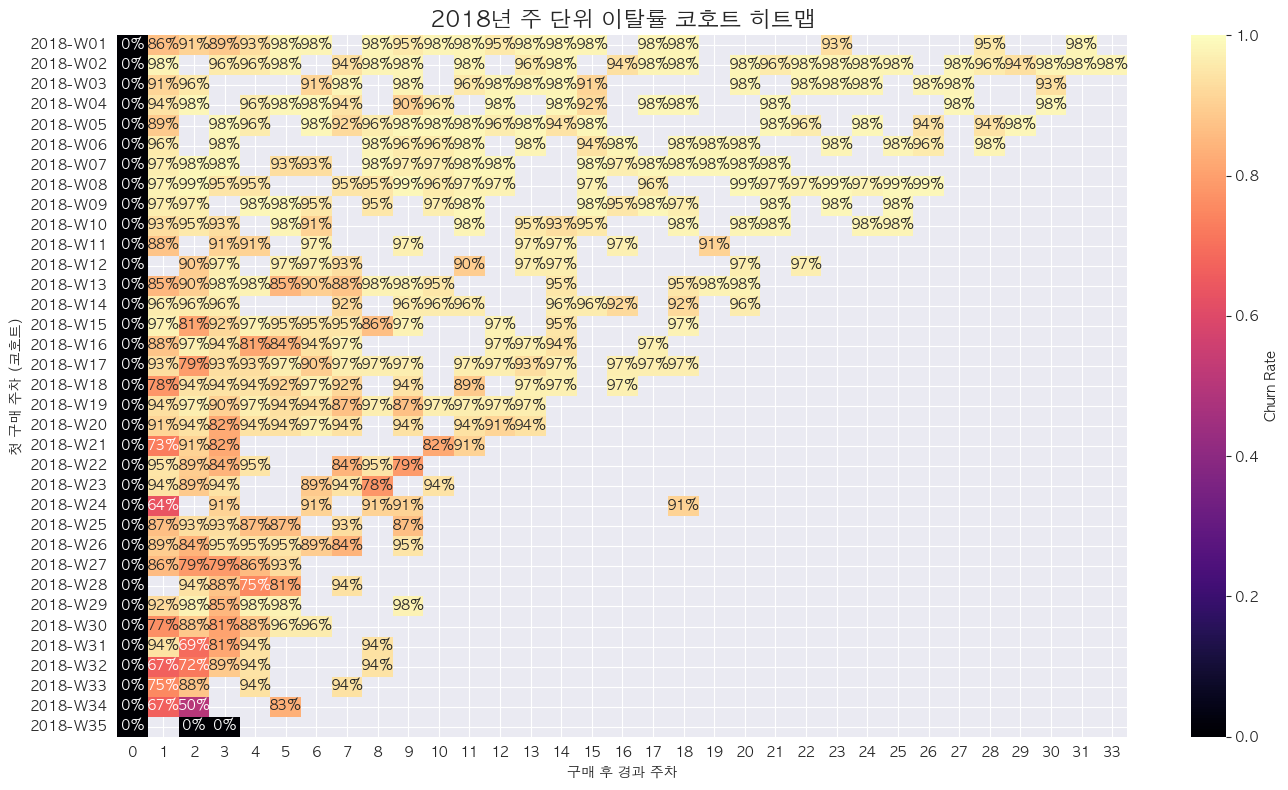

In [365]:
# 연도 추출 (cohort_week 예: '2016-W01')
cohort_data['cohort_year'] = cohort_data['cohort_week'].str[:4]

# 연도별 반복 시각화
for year in ['2016', '2017', '2018']:
    # 해당 연도 데이터 필터링
    cohort_year_data = cohort_data[cohort_data['cohort_year'] == year]

    # 피벗 테이블 생성
    churn_pivot = cohort_year_data.pivot(
        index='cohort_week',
        columns='weeks_since_first',
        values='churn_rate'
    )

    # 히트맵 시각화
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        churn_pivot,
        annot=True,
        fmt=".0%",
        cmap='magma',
        vmin=0.0,
        vmax=1.0,
        cbar_kws={'label': 'Churn Rate'}
    )

    plt.title(f'{year}년 주 단위 이탈률 코호트 히트맵', fontsize=16)
    plt.xlabel('구매 후 경과 주차')
    plt.ylabel('첫 구매 주차 (코호트)')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [394]:
# 마지막 구매일 : 2018-10-16 20:16:02
filtered_customers['order_purchase_timestamp'].describe()

count                             6099
mean     2017-12-09 05:09:45.234956544
min                2016-10-03 09:44:50
25%         2017-08-14 15:59:22.500000
50%                2017-12-17 18:45:57
75%         2018-04-08 12:52:17.500000
max                2018-10-16 20:16:02
Name: order_purchase_timestamp, dtype: object

In [397]:
# 2. 주문 시간 기준으로 정렬
filtered_customers_sorted = filtered_customers.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
filtered_customers_sorted['order_rank'] = filtered_customers_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = filtered_customers_sorted[filtered_customers_sorted['order_rank'].isin([1, 2])]

# 5. 첫 번째와 두 번째 구매만 남긴 후 reshape
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # rank 1, 2에 맞게 이름 지정

# 6. 소요일 계산 (두 번째 - 첫 번째)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 약 80일(2~3개월) 중위값(28일)
average_days = order_diff_df['days_between'].mean()
print(f"평균 소요일: {average_days:.2f}일")
order_diff_df['days_between'].describe()

                                         first_order        second_order  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02 2018-07-28 00:23:49 2018-08-13 09:14:07   
004288347e5e88a27ded2bb23747066c 2017-07-27 14:13:03 2018-01-14 07:36:54   
004b45ec5c64187465168251cd1c9c2f 2017-09-01 12:11:23 2018-05-26 19:42:48   
0058f300f57d7b93c477a131a59b36c3 2018-02-19 17:11:34 2018-03-22 18:09:41   
00a39521eb40f7012db50455bf083460 2018-05-23 20:14:21 2018-06-03 10:12:57   

                                  days_between  
customer_unique_id                              
00172711b30d52eea8b313a7f2cced02            16  
004288347e5e88a27ded2bb23747066c           170  
004b45ec5c64187465168251cd1c9c2f           267  
0058f300f57d7b93c477a131a59b36c3            31  
00a39521eb40f7012db50455bf083460            10  
평균 소요일: 80.40일


count    2948.00000
mean       80.40095
std       110.34067
min         0.00000
25%         0.00000
50%        28.00000
75%       124.00000
max       608.00000
Name: days_between, dtype: float64

In [380]:
# 3회 구매 고객
customers_3 = purchase_frequency[purchase_frequency['purchase_count'] == 3]
customers_3 = filtered_customers[filtered_customers['customer_unique_id'].isin(customers_3['customer_unique_id'])]

customers_3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_month
5,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30 00:00:00,51838d41add414a0b1b989b7d251d9ee,2017-03-01
22,7e3e92dc3eaf5389f32da97228f7dd0e,62d50e9a714ac024c196d9548594e2aa,delivered,2017-07-02 20:47:24,2017-07-02 21:03:55,2017-07-03 11:42:08,2017-07-11 20:22:31,2017-07-25 00:00:00,ba77e9b6506636dcbd03e463d4786f24,2017-07-01
27,dc400373e624e9b0435847a79813c658,4a00f00d951c167739888a1f16c56e8e,delivered,2018-01-14 18:49:14,2018-01-14 18:59:30,2018-01-16 20:15:54,2018-01-20 14:28:43,2018-01-30 00:00:00,d02cbb85434c84acabb8e81bbf064d3e,2018-01-01
29,a7076e7aba13de8b66d95a55811290ed,1ae196062dab95e434e781a5319f0ab9,delivered,2018-05-14 11:04:55,2018-05-15 04:35:02,2018-05-15 16:22:00,2018-05-21 20:32:38,2018-06-04 00:00:00,02e9109b7e0a985108b43e573b6afb23,2018-05-01
38,d4922affdd87d3e42657243354c7acd1,3a6586139c630a9648d74d1da4a11cd8,delivered,2018-07-01 21:12:33,2018-07-01 21:29:50,2018-07-03 10:15:00,2018-07-06 16:50:48,2018-07-30 00:00:00,8cd6f80d3c3994e2060d46ec07ff0b0a,2018-07-01


In [388]:
# 3회 구매 고객: 첫 번째 구매 이후 두 번째 구매까지 소요일

# 2. 주문 시간 기준으로 정렬
customers_3_sorted = customers_3.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
customers_3_sorted['order_rank'] = customers_3_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = customers_3_sorted[customers_3_sorted['order_rank'].isin([1, 2])]

# 5. 첫 번째와 두 번째 구매만 남긴 후 reshape
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # rank 1, 2에 맞게 이름 지정

# 6. 소요일 계산 (두 번째 - 첫 번째)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 약 74일(2~3개월)
average_days = order_diff_df['days_between'].mean()
print(f"평균 소요일: {average_days:.2f}일")

                                         first_order        second_order  \
customer_unique_id                                                         
02e9109b7e0a985108b43e573b6afb23 2017-11-23 16:19:10 2018-05-13 23:53:10   
041caba6a63ace5818387698ea85cdb2 2017-03-15 21:50:14 2017-11-17 08:47:41   
043aee247e71edff7045664609f4d806 2017-03-22 12:29:08 2017-05-25 16:12:51   
06a52782a04f0086d16b9c22d0e29438 2017-05-06 20:11:10 2017-05-06 20:11:10   
07b1b60bca2b6326fa2adb259ea4a55f 2018-03-26 22:19:07 2018-03-30 15:47:09   

                                  days_between  
customer_unique_id                              
02e9109b7e0a985108b43e573b6afb23           171  
041caba6a63ace5818387698ea85cdb2           246  
043aee247e71edff7045664609f4d806            64  
06a52782a04f0086d16b9c22d0e29438             0  
07b1b60bca2b6326fa2adb259ea4a55f             3  
평균 소요일: 74.28일


In [389]:
order_diff_df['days_between'].describe() # 중위값: 33일

count    203.000000
mean      74.275862
std       99.488308
min        0.000000
25%        0.000000
50%       33.000000
75%      112.000000
max      509.000000
Name: days_between, dtype: float64

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.yscale('log')  # 로그 스케일
plt.title('고객별 구매 횟수 분포 (비율 표시)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수 (log scale)')
plt.grid(True)

# 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:  # 0인 경우 표시 생략
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%',
                 ha='center', va='bottom', fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [390]:
# 2회 구매 고객
customers_2 = purchase_frequency[purchase_frequency['purchase_count'] == 2]
customers_2 = filtered_customers[filtered_customers['customer_unique_id'].isin(customers_2['customer_unique_id'])]

customers_2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,2017-10-01
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,2018-06-01
2,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5,2018-01-01
3,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,2018-06-01
4,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,delivered,2017-05-14 20:28:25,2017-05-14 20:42:45,2017-05-16 08:17:46,2017-05-25 09:14:31,2017-06-12 00:00:00,c2551ea089b7ebbc67a2ea8757152514,2017-05-01


In [392]:
# 2회 구매 고객:  첫 번째 구매 이후 두 번째 구매까지 소요일

# 2. 고객별 주문 시간 순으로 정렬
customers_2_sorted = customers_2.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
customers_2_sorted['order_rank'] = customers_2_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = customers_2_sorted[customers_2_sorted['order_rank'].isin([1, 2])]

# 5. Pivot: 첫 번째와 두 번째 구매 시간 분리
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # 컬럼명 명확히 지정

# 6. 소요일 계산 (second - first)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 80일(2~3개월)
average_days = order_diff_df['days_between'].mean()
print(f"2회 구매 고객의 평균 소요일: {average_days:.2f}일")

                                         first_order        second_order  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02 2018-07-28 00:23:49 2018-08-13 09:14:07   
004288347e5e88a27ded2bb23747066c 2017-07-27 14:13:03 2018-01-14 07:36:54   
004b45ec5c64187465168251cd1c9c2f 2017-09-01 12:11:23 2018-05-26 19:42:48   
0058f300f57d7b93c477a131a59b36c3 2018-02-19 17:11:34 2018-03-22 18:09:41   
00a39521eb40f7012db50455bf083460 2018-05-23 20:14:21 2018-06-03 10:12:57   

                                  days_between  
customer_unique_id                              
00172711b30d52eea8b313a7f2cced02            16  
004288347e5e88a27ded2bb23747066c           170  
004b45ec5c64187465168251cd1c9c2f           267  
0058f300f57d7b93c477a131a59b36c3            31  
00a39521eb40f7012db50455bf083460            10  
2회 구매 고객의 평균 소요일: 80.85일


In [393]:
order_diff_df['days_between'].describe() # 중위값: 28일

count    2745.000000
mean       80.853916
std       111.104238
min         0.000000
25%         0.000000
50%        28.000000
75%       125.000000
max       608.000000
Name: days_between, dtype: float64

## 이탈 고객: 마지막 구매일로부터 1개월/3개월 이상 재구매를 하지 않은 고객

In [ ]:
# 마지막 구매일로부터 3개월 내 구매하지 않은 고객 비율

In [ ]:
# 마지막 구매일로부터 1개월 내 구매하지 않은 고객 비율

# products_dataset

In [140]:
products_df = pd.read_csv('data/olist_products_dataset.csv')
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [141]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [142]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [150]:
products_df.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [151]:
# 등록 카테고리 수: 73건
products_df['product_category_name'].nunique()

73